# Confirm that code can produce values in textbook for case with terminal states

## The result of running this notebook is that the utilities approximately matches that in the textbook for case with terminal states, gamma discount factor is 1, step cost is -.04

### Results of running this notebook:

In [ ]:
from IPython.display import Image

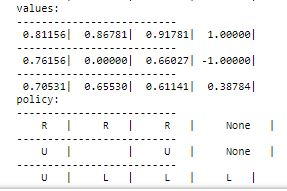

In [51]:
Image(filename = "confirm_textbook_answers_1.JPG", width = 600, height = 300)

### Utilities in the textbook:

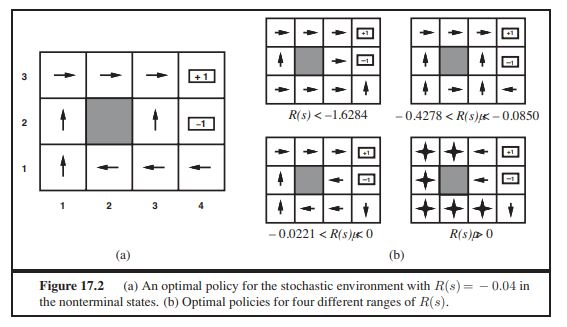

In [32]:
Image(filename = "textbook_answers_1.JPG", width = 600, height = 300)

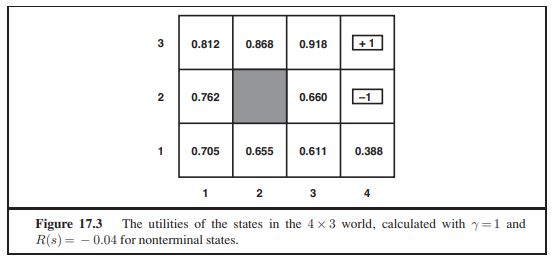

In [33]:
Image(filename = "textbook_answers_2.JPG", width = 600, height = 300)

# ------------------------------------------------------------------------------------------------


# ------------------------------------------------------------------------------------------------


### Please note that (row,col) format is used for the code, and the uppermost left cell is (0,0)

In [40]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

class Grid:
    def __init__(self, width, height, start):  #start is a tuple of 2 integars
        self.width = width
        self.height = height
        self.i = start[0]
        self.j = start[1]
        
    def set(self, rewards, actions):  #set the rewards and actions of the environment
        #rewards in dict of: (i, j): (row, col): reward
        #actions in dict of: (i, j): A (row, col): list of possible actions
        self.rewards = rewards
        self.actions = actions  #enumerate all the possible actions that can take you to new state
    
    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]
        
    def current_state(self):
        return (self.i, self.j)

    def is_terminal(self, s):
        return s not in self.actions
    
    def move(self, action):
        #check if legal move first
        if action in self.actions[(self.i, self.j)]:
            if action == 'U':
                self.i -= 1
            elif action == 'D':
                self.i += 1
            elif action == 'R':
                self.j += 1
            elif action == 'L':
                self.j -= 1
        else:
            pass
        #return a reward (if any)
        return self.rewards.get((self.i, self.j), 0)
    
    def undo_move(self, action):
        #these are the opposite of what U/D/L/R should normally do
        if action == 'U':
            self.i += 1
        elif action == 'D':
            self.i -= 1
        elif action == 'R':
            self.j -= 1
        elif action == 'L':
            self.j += 1
            
        #raise an exception if we arrive somewhere we shouldn't be
        assert(self.current_state() in self.all_states())
    
    def game_over(self):
        #returns true if game is over, else false
        #true if we are in a state where no actions are possible
        return (self.i, self.j) not in self.actions
    
    def all_states(self):
        return set(list(self.actions.keys()) + list(self.rewards.keys()))
    
def standard_grid():
    #define a grid that describes the reward for arriving at each state
    #and possible actions at each state
    g = Grid(3, 4, (2, 0))
    rewards = {(0,3): 1, (1,3): -1}
    actions = {
        (0,0): ('D', 'R'),
        (0,1): ('L', 'R'),
        (0,2): ('L', "D", 'R'),
        (1,0): ('U', 'D'),
        (1,2): ('U', 'D', 'R'),
        (2,0): ('U', 'R'),
        (2,1): ('L', 'R'),
        (2,2): ('L', 'R', 'U'),
        (2,3): ('L', 'U'),
        #(0,3): ('L', 'D'),                
        #(1,3): ('U', 'D', 'L')            
    }
    g.set(rewards, actions)
    return g

def negative_grid(step_cost=-0.04):
    g = standard_grid()
    g.rewards.update({
        (0,0): step_cost,
        (0,1): step_cost,
        (0,2): step_cost,
        (1,0): step_cost,
        (1,2): step_cost,
        (2,0): step_cost,
        (2,1): step_cost,
        (2,2): step_cost,
        (2,3): step_cost,
    })
    return g

def play_game(agent, env):
    pass

In [41]:
SMALL_ENOUGH = 10e-4 #threshold for convergence

hist = []

def print_values(V, g):
    for i in range(g.width):
        print("--------------------------")
        for j in range(g.height):
            v = V.get((i,j), 0)
            if v >= 0:
                print(' {:.5f}|'.format(v), end = ' ')
            else:
                print('{:.5f}|'.format(v), end = ' ') # -ve sign takes up an extra space
                
            hist.append(v)
                
        print ("")

def print_policy(P,g):
    for i in range(g.width):
        print("--------------------------")
        for j in range(g.height):
            a = P.get((i,j), ' ')
            print('    {}   |'.format(a), end = ' ')
        print ("")

In [74]:
SMALL_ENOUGH = 10e-4
GAMMA = 1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

if __name__ == '__main__':
    
    grid = negative_grid()
    
    print("rewards:")
    print_values(grid.rewards, grid)
    
    #randomly choose an action and update as we learn
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
        
    #initial policy
    print('initial policy:')
    print_policy(policy, grid)
    
    
    hist = []
    
    
    #initilize V(s)
    V = {}
    states = grid.all_states()
    for s in states: 
        V[s] = 0
        if s in grid.actions:
            #V[s] = 0
            V[s] = np.random.random()
        else:
            #terminal state
            V[s] = 0
            
    V[(0,3)] = 1
    V[(1,3)] = -1  
            
    print_values(V, grid)
    
    #repeat until convergence
    while True:
        
        #policy evaluation step
        while True:
            biggest_change = 0
            for s in states:
                old_v = V[s]
                
                
                if s in policy:
                    a = policy[s]
                    grid.set_state(s)
                    try:
                        r = grid.move(a)
                    except KeyError:
                        continue
                    
                    
                    grid.set_state(s)
                    #r = grid.move(a) #move only when legal / possible. Returns reward. 
                    r = grid.rewards.get(grid.current_state(), 0)
                    
                    
                    _ = grid.move(a)
                    v_correct = V[grid.current_state()]
                    
                    grid.set_state(s)
                    if a == 'U':
                        r_clockwise = grid.move('R')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('L')
                    elif a == 'R':
                        r_clockwise = grid.move('D')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('U')
                    elif a == 'D':
                        r_clockwise = grid.move('L')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('R')
                    elif a == 'L':
                        r_clockwise = grid.move('U')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('D')
                        
                    v_anticlockwise = V[grid.current_state()]
                        
                        
                    v = r + GAMMA * (0.8*v_correct + 0.1*v_clockwise + 0.1*v_anticlockwise)
                    V[s] = v
                    
                    biggest_change = max(biggest_change, np.abs(old_v - V[s]))
                    

            if biggest_change < SMALL_ENOUGH:
                break
        
            
            print('values:')
            print_values(V, grid)
            print('policy:')
            print_policy(policy, grid)
        
        
        #policy improvement step
        is_policy_converged = True
        for s in states:
            if s in policy:
                old_a = policy[s]
                new_a = None
                best_value = float('-inf')
                # loop through all possible actions to find the best current action
                for a in ALL_POSSIBLE_ACTIONS:
                    grid.set_state(s)
                    try:
                        r = grid.move(a)
                    except KeyError:
                        continue
                    
                    grid.set_state(s)
                    #r = grid.move(a) #move only when legal / possible. Returns reward. 
                    r = grid.rewards.get(grid.current_state(), 0)
                    
                    
                    _ = grid.move(a)
                    v_correct = V[grid.current_state()]
                    
                    grid.set_state(s)
                    if a == 'U':
                        r_clockwise = grid.move('R')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('L')
                    elif a == 'R':
                        r_clockwise = grid.move('D')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('U')
                    elif a == 'D':
                        r_clockwise = grid.move('L')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('R')
                    elif a == 'L':
                        r_clockwise = grid.move('U')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('D')
                        
                    v_anticlockwise = V[grid.current_state()]
            
                    v = r + GAMMA * (0.8*v_correct + 0.1*v_clockwise + 0.1*v_anticlockwise)
                    
                    
                    if v > best_value:
                        best_value = v
                        new_a = a
            policy[s] = new_a
            if new_a != old_a:
                is_policy_converged = False
        
        if is_policy_converged:
            break
    print('values:')
    print_values(V, grid)
    print('policy:')
    print_policy(policy, grid)

rewards:
--------------------------
-0.04000| -0.04000| -0.04000|  1.00000| 
--------------------------
-0.04000|  0.00000| -0.04000| -1.00000| 
--------------------------
-0.04000| -0.04000| -0.04000| -0.04000| 
initial policy:
--------------------------
    L   |     U   |     R   |         | 
--------------------------
    R   |         |     U   |         | 
--------------------------
    D   |     U   |     U   |     L   | 
--------------------------
 0.16994|  0.97344|  0.55307|  1.00000| 
--------------------------
 0.40632|  0.00000|  0.02319| -1.00000| 
--------------------------
 0.94934|  0.84540|  0.08580|  0.50777| 
values:
--------------------------
 0.15357|  0.81105|  0.84578|  1.00000| 
--------------------------
 0.38925|  0.00000|  0.30478| -1.00000| 
--------------------------
 0.88839|  0.73984|  0.27575| -0.02058| 
policy:
--------------------------
    L   |     U   |     R   |         | 
--------------------------
    R   |         |     U   |         | 
-------

    L   |     U   |     R   |         | 
--------------------------
    R   |         |     U   |         | 
--------------------------
    D   |     U   |     U   |     L   | 
values:
--------------------------
-1.14440| -0.25741|  0.91781|  1.00000| 
--------------------------
-0.94704|  0.00000|  0.66027| -1.00000| 
--------------------------
-0.48130| -0.16181|  0.50109|  0.29050| 
policy:
--------------------------
    L   |     U   |     R   |         | 
--------------------------
    R   |         |     U   |         | 
--------------------------
    D   |     U   |     U   |     L   | 
values:
--------------------------
-1.16466| -0.26859|  0.91781|  1.00000| 
--------------------------
-0.96309|  0.00000|  0.66027| -1.00000| 
--------------------------
-0.48992| -0.16747|  0.50046|  0.28992| 
policy:
--------------------------
    L   |     U   |     R   |         | 
--------------------------
    R   |         |     U   |         | 
--------------------------
    D   |     U 

    R   |         |     U   |         | 
--------------------------
    D   |     U   |     U   |     L   | 
values:
--------------------------
-1.65760| -0.54739|  0.91781|  1.00000| 
--------------------------
-1.33536|  0.00000|  0.66027| -1.00000| 
--------------------------
-0.65930| -0.27872|  0.48820|  0.27856| 
policy:
--------------------------
    L   |     U   |     R   |         | 
--------------------------
    R   |         |     U   |         | 
--------------------------
    D   |     U   |     U   |     L   | 
values:
--------------------------
-1.66537| -0.55189|  0.91781|  1.00000| 
--------------------------
-1.34096|  0.00000|  0.66027| -1.00000| 
--------------------------
-0.66138| -0.28009|  0.48805|  0.27842| 
policy:
--------------------------
    L   |     U   |     R   |         | 
--------------------------
    R   |         |     U   |         | 
--------------------------
    D   |     U   |     U   |     L   | 
values:
--------------------------
-1.67293

--------------------------
-1.83572| -0.65138|  0.91781|  1.00000| 
--------------------------
-1.46139|  0.00000|  0.66027| -1.00000| 
--------------------------
-0.70172| -0.30659|  0.48513|  0.27571| 
policy:
--------------------------
    L   |     U   |     R   |         | 
--------------------------
    R   |         |     U   |         | 
--------------------------
    D   |     U   |     U   |     L   | 
values:
--------------------------
-1.83828| -0.65290|  0.91781|  1.00000| 
--------------------------
-1.46316|  0.00000|  0.66027| -1.00000| 
--------------------------
-0.70224| -0.30693|  0.48509|  0.27568| 
policy:
--------------------------
    L   |     U   |     R   |         | 
--------------------------
    R   |         |     U   |         | 
--------------------------
    D   |     U   |     U   |     L   | 
values:
--------------------------
-1.84077| -0.65436|  0.91781|  1.00000| 
--------------------------
-1.46488|  0.00000|  0.66027| -1.00000| 
----------------

 0.81156|  0.86781|  0.91781|  1.00000| 
--------------------------
 0.76156|  0.00000|  0.66027| -1.00000| 
--------------------------
 0.70529|  0.65519|  0.60925|  0.36945| 
policy:
--------------------------
    R   |     R   |     R   |     None   | 
--------------------------
    U   |         |     U   |     None   | 
--------------------------
    U   |     L   |     L   |     L   | 
values:
--------------------------
 0.81156|  0.86781|  0.91781|  1.00000| 
--------------------------
 0.76156|  0.00000|  0.66027| -1.00000| 
--------------------------
 0.70530|  0.65527|  0.61117|  0.38434| 
policy:
--------------------------
    R   |     R   |     R   |     None   | 
--------------------------
    U   |         |     U   |     None   | 
--------------------------
    U   |     L   |     L   |     L   | 
values:
--------------------------
 0.81156|  0.86781|  0.91781|  1.00000| 
--------------------------
 0.76156|  0.00000|  0.66027| -1.00000| 
--------------------------
 0.7

In [75]:
iterations = int(len(hist)/12)

hist_0_0 = []
hist_0_1 = []
hist_0_2 = []
hist_0_3 = [] #

hist_1_0 = []
hist_1_1 = [] #
hist_1_2 = []
hist_1_3 = [] #

hist_2_0 = []
hist_2_1 = []
hist_2_2 = []
hist_2_3 = []

print(iterations)
for i in range(iterations):
    hist_0_0.append(hist[0+i*12])
    hist_0_1.append(hist[1+i*12])
    hist_0_2.append(hist[2+i*12])
    hist_0_3.append(hist[3+i*12]) #
    
    hist_1_0.append(hist[4+i*12])
    hist_1_1.append(hist[5+i*12]) #
    hist_1_2.append(hist[6+i*12]) 
    hist_1_3.append(hist[7+i*12]) #
    
    hist_2_0.append(hist[8+i*12])
    hist_2_1.append(hist[9+i*12]) 
    hist_2_2.append(hist[10+i*12])
    hist_2_3.append(hist[11+i*12])

182


In [76]:
hist_0_3 = [1 for x in range(iterations)]
hist_1_3 = [-1 for x in range(iterations)]

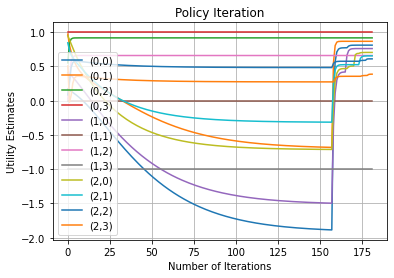

In [77]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = [i for i in range(iterations)]

fig, ax = plt.subplots()
ax.plot(x, hist_0_0)
ax.plot(x, hist_0_1)
ax.plot(x, hist_0_2)
ax.plot(x, hist_0_3)

ax.plot(x, hist_1_0)
ax.plot(x, hist_1_1)
ax.plot(x, hist_1_2)
ax.plot(x, hist_1_3)

ax.plot(x, hist_2_0)
ax.plot(x, hist_2_1)
ax.plot(x, hist_2_2)
ax.plot(x, hist_2_3)

plt.legend(["(0,0)", "(0,1)", "(0,2)", "(0,3)", "(1,0)", "(1,1)", "(1,2)", "(1,3)", "(2,0)", "(2,1)", "(2,2)", "(2,3)"], loc ="lower left")


ax.set(xlabel='Number of Iterations', ylabel='Utility Estimates', title='Policy Iteration')
ax.grid()

fig.savefig("test.png")
plt.show()

In [80]:
#value iteration
import numpy as np
import matplotlib.pyplot as plt

SMALL_ENOUGH = 10e-4
GAMMA = 1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')


if __name__ == '__main__':
    
    grid = negative_grid()

       
    #print rewards
    print("rewards:")
    print_values(grid.rewards, grid)
    

    #randomly choose an action and update as we learn
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
    
    #initial policy
    print("initial policy:")
    print_policy(policy, grid)
    
    hist = []
    
    #initialize V(s)
    V = {}
    states = grid.all_states()
    for s in states:
        if s in grid.actions:
            V[s] = 0
        else:
            #terminal state
            V[s] = 0
    
    V[(0,3)] = 1
    V[(1,3)] = -1  
    
    #repeat until convergenece
    while True:
        biggest_change = 0
        for s in states: 
            old_v = V[s]
            
            if s in policy: 
                new_v = float('-inf')
                for a in ALL_POSSIBLE_ACTIONS:
                    
                    grid.set_state(s)
                    #r = grid.move(a) #move only when legal / possible. Returns reward. 
                    r = grid.rewards.get(grid.current_state(), 0)
                    
                    
                    _ = grid.move(a)
                    v_correct = V[grid.current_state()]
                    
                    grid.set_state(s)
                    if a == 'U':
                        r_clockwise = grid.move('R')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('L')
                    elif a == 'R':
                        r_clockwise = grid.move('D')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('U')
                    elif a == 'D':
                        r_clockwise = grid.move('L')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('R')
                    elif a == 'L':
                        r_clockwise = grid.move('U')
                        v_clockwise = V[grid.current_state()]
                        grid.set_state(s)
                        r_anticlockwise = grid.move('D')
                        
                    v_anticlockwise = V[grid.current_state()]
                        
                        
                    v = r + GAMMA * (0.8*v_correct + 0.1*v_clockwise + 0.1*v_anticlockwise)
                    
                    if v > new_v:
                        new_v = v
                V[s] = new_v #update value if needed to
                biggest_change = max(biggest_change, np.abs(old_v - V[s]))
                
                
                print('Values:')
                print_values(V, grid)

                
        if biggest_change < SMALL_ENOUGH:
            break
            
            
    #find a policy that leads to optimal value function
    for s in policy.keys():
        best_a = None
        best_value = float('-inf')
        #loop through all possible actions to ind the best current action
        for a in ALL_POSSIBLE_ACTIONS:
            
            grid.set_state(s)
            r = grid.rewards.get(grid.current_state(), 0)
                    
                    
            _ = grid.move(a)
            v_correct = V[grid.current_state()]
                    
            grid.set_state(s)
            if a == 'U':
                r_clockwise = grid.move('R')
                v_clockwise = V[grid.current_state()]
                grid.set_state(s)
                r_anticlockwise = grid.move('L')
            elif a == 'R':
                r_clockwise = grid.move('D')
                v_clockwise = V[grid.current_state()]
                grid.set_state(s)
                r_anticlockwise = grid.move('U')
            elif a == 'D':
                r_clockwise = grid.move('L')
                v_clockwise = V[grid.current_state()]
                grid.set_state(s)
                r_anticlockwise = grid.move('R')
            elif a == 'L':
                r_clockwise = grid.move('U')
                v_clockwise = V[grid.current_state()]
                grid.set_state(s)
                r_anticlockwise = grid.move('D')
                        
            v_anticlockwise = V[grid.current_state()] 
                        
            v = r + GAMMA * (0.8*v_correct + 0.1*v_clockwise + 0.1*v_anticlockwise)
            
            
            if v > best_value:
                best_value = v
                best_a = a
        policy[s] = best_a
        
    print('values:')
    print_values(V, grid)
    print('policy:')
    print_policy(policy, grid)

rewards:
--------------------------
-0.04000| -0.04000| -0.04000|  1.00000| 
--------------------------
-0.04000|  0.00000| -0.04000| -1.00000| 
--------------------------
-0.04000| -0.04000| -0.04000| -0.04000| 
initial policy:
--------------------------
    U   |     R   |     L   |         | 
--------------------------
    L   |         |     U   |         | 
--------------------------
    R   |     L   |     D   |     D   | 
Values:
--------------------------
 0.00000| -0.04000|  0.00000|  1.00000| 
--------------------------
 0.00000|  0.00000|  0.00000| -1.00000| 
--------------------------
 0.00000|  0.00000|  0.00000|  0.00000| 
Values:
--------------------------
 0.00000| -0.04000|  0.00000|  1.00000| 
--------------------------
 0.00000|  0.00000| -0.04000| -1.00000| 
--------------------------
 0.00000|  0.00000|  0.00000|  0.00000| 
Values:
--------------------------
 0.00000| -0.04000|  0.00000|  1.00000| 
--------------------------
 0.00000|  0.00000| -0.04000| -1.00000| 

 0.70403|  0.65320|  0.60576|  0.37509| 
Values:
--------------------------
 0.81153|  0.86781|  0.91781|  1.00000| 
--------------------------
 0.76140|  0.00000|  0.66027| -1.00000| 
--------------------------
 0.70403|  0.65320|  0.60576|  0.37509| 
Values:
--------------------------
 0.81153|  0.86781|  0.91781|  1.00000| 
--------------------------
 0.76140|  0.00000|  0.66027| -1.00000| 
--------------------------
 0.70484|  0.65320|  0.60576|  0.37509| 
Values:
--------------------------
 0.81153|  0.86781|  0.91781|  1.00000| 
--------------------------
 0.76140|  0.00000|  0.66027| -1.00000| 
--------------------------
 0.70484|  0.65320|  0.60576|  0.38211| 
Values:
--------------------------
 0.81153|  0.86781|  0.91781|  1.00000| 
--------------------------
 0.76140|  0.00000|  0.66027| -1.00000| 
--------------------------
 0.70484|  0.65320|  0.60576|  0.38211| 
Values:
--------------------------
 0.81153|  0.86781|  0.91781|  1.00000| 
--------------------------
 0.76140

In [81]:
iterations = int(len(hist)/12)

hist_0_0 = []
hist_0_1 = []
hist_0_2 = []
hist_0_3 = [] #

hist_1_0 = []
hist_1_1 = [] #
hist_1_2 = []
hist_1_3 = [] #

hist_2_0 = []
hist_2_1 = []
hist_2_2 = []
hist_2_3 = []

print(iterations)
for i in range(iterations):
    hist_0_0.append(hist[0+i*12])
    hist_0_1.append(hist[1+i*12])
    hist_0_2.append(hist[2+i*12])
    hist_0_3.append(hist[3+i*12]) #
    
    hist_1_0.append(hist[4+i*12])
    hist_1_1.append(hist[5+i*12]) #
    hist_1_2.append(hist[6+i*12]) 
    hist_1_3.append(hist[7+i*12]) #
    
    hist_2_0.append(hist[8+i*12])
    hist_2_1.append(hist[9+i*12]) 
    hist_2_2.append(hist[10+i*12])
    hist_2_3.append(hist[11+i*12])

127


In [82]:
hist_0_3 = [1 for x in range(iterations)]
hist_1_3 = [-1 for x in range(iterations)]

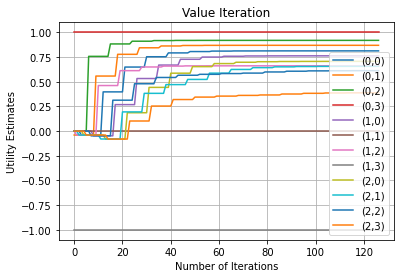

In [83]:
x = [i for i in range(iterations)]

fig, ax = plt.subplots()
ax.plot(x, hist_0_0)
ax.plot(x, hist_0_1)
ax.plot(x, hist_0_2)
ax.plot(x, hist_0_3)

ax.plot(x, hist_1_0)
ax.plot(x, hist_1_1)
ax.plot(x, hist_1_2)
ax.plot(x, hist_1_3)

ax.plot(x, hist_2_0)
ax.plot(x, hist_2_1)
ax.plot(x, hist_2_2)
ax.plot(x, hist_2_3)

plt.legend(["(0,0)", "(0,1)", "(0,2)", "(0,3)", "(1,0)", "(1,1)", "(1,2)", "(1,3)", "(2,0)", "(2,1)", "(2,2)", "(2,3)"], loc ="lower right")


ax.set(xlabel='Number of Iterations', ylabel='Utility Estimates', title='Value Iteration')
ax.grid()

fig.savefig("test.png")
plt.show()